# Тестирование Метода главных компанент и LSTM сетей для предсказания временных рядов

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, LSTM
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from keras.regularizers import l2

In [30]:
usd_d = pd.read_csv("usd.csv")
usd_d['Цена'] = usd_d['Цена'].str.replace(',', '.').astype(float)
usd_d['Дата'] = pd.to_datetime(usd_d['Дата'], format='%d.%m.%Y')  # Преобразование столбца с датами в формат даты
usd_d = usd_d.sort_values(by='Дата')
usd_d.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
764,2020-09-07,75.7585,"75,4087","76,2455","75,4087",NaN,"0,46%"
763,2020-09-08,76.2826,"75,7585","76,5688","75,7328",NaN,"0,69%"
762,2020-09-09,75.3163,"76,2826","76,3873","75,2898",NaN,"-1,27%"
761,2020-09-10,75.2048,"75,3163","75,6695","74,6810",NaN,"-0,15%"
760,2020-09-11,75.0956,"75,2048","75,2048","74,7645",NaN,"-0,15%"


In [31]:
eur_d = pd.read_csv("eur.csv")
eur_d['Цена'] = eur_d['Цена'].str.replace(',', '.').astype(float)
eur_d['Дата'] = pd.to_datetime(eur_d['Дата'], format='%d.%m.%Y')  # Преобразование столбца с датами в формат даты
eur_d = eur_d.sort_values(by='Дата')
eur_d.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
774,2020-09-07,89.557,"89,250","90,073","89,228",NaN,"0,34%"
773,2020-09-08,89.879,"89,557","90,255","89,413",NaN,"0,36%"
772,2020-09-09,88.960,"89,879","89,900","88,880",NaN,"-1,02%"
771,2020-09-10,88.871,"88,960","89,467","88,782",NaN,"-0,10%"
770,2020-09-11,88.845,"88,871","89,000","88,535",NaN,"-0,03%"


In [32]:
gold_d = pd.read_csv("gold.csv")
gold_d['Цена'] = gold_d['Цена'].str.replace('.', '').str.replace(',', '.').astype(float)
gold_d['Дата'] = pd.to_datetime(gold_d['Дата'], format='%d.%m.%Y')  # Преобразование столбца с датами в формат даты
gold_d = gold_d.sort_values(by='Дата')
gold_d.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
782,2020-09-07,1943.2,"1.938,00","1.948,30","1.911,70","416,01K","0,46%"
781,2020-09-08,1939.5,"1.937,40","1.937,40","1.909,00","0,04K","-0,19%"
780,2020-09-09,1954.9,"1.939,40","1.959,70","1.926,30","227,18K","0,79%"
779,2020-09-10,1964.3,"1.955,30","1.975,20","1.948,60","271,48K","0,48%"
778,2020-09-11,1947.9,"1.953,80","1.963,40","1.944,00","205,23K","-0,83%"


In [33]:
merged_df = gold_d.merge(usd_d, on='Дата').merge(eur_d, on='Дата')
merged_df.tail()

,Дата,Цена_x,Откр._x,Макс._x,Мин._x,Объём_x,Изм. %_x,Цена_y,Откр._y,Макс._y,Мин._y,Объём_y,Изм. %_y,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
754,2023-08-31,1965.90,"1.970,20","1.974,90","1.965,50","133,71K","-0,36%",96.0250,"96,2200","96,6450","95,7018",NaN,"-0,20%",103.965,"105,048","105,431","103,645",NaN,"-1,03%"
755,2023-09-01,1967.10,"1.966,40","1.980,20","1.960,70","160,73K","0,06%",96.0900,"96,0250","96,7041","95,8468",NaN,"0,07%",103.872,"103,965","105,013","103,858",NaN,"-0,09%"
756,2023-09-04,1963.25,"1.966,60","1.972,55","1.962,55",NaN,"-0,17%",96.8700,"96,0900","96,9349","96,0900",NaN,"0,81%",104.578,"104,000","104,840","103,919",NaN,"0,68%"
757,2023-09-05,1952.60,"1.966,70","1.972,60","1.950,60",NaN,"-0,54%",97.9050,"96,8700","97,9050","96,8700",NaN,"1,07%",105.051,"104,578","105,334","104,553",NaN,"0,45%"
758,2023-09-06,1951.75,"1.951,85","1.953,65","1.947,65",NaN,"-0,04%",97.7648,"97,9050","98,3367","97,4246",NaN,"-0,14%",105.124,"105,051","105,318","104,764",NaN,"0,07%"


In [34]:
df = merged_df[['Цена_x', 'Цена_y', 'Цена']].to_numpy()
df

array([[1943.2   ,   75.7585,   89.557 ],
       [1939.5   ,   76.2826,   89.879 ],
       [1954.9   ,   75.3163,   88.96  ],
       ...,
       [1963.25  ,   96.87  ,  104.578 ],
       [1952.6   ,   97.905 ,  105.051 ],
       [1951.75  ,   97.7648,  105.124 ]])

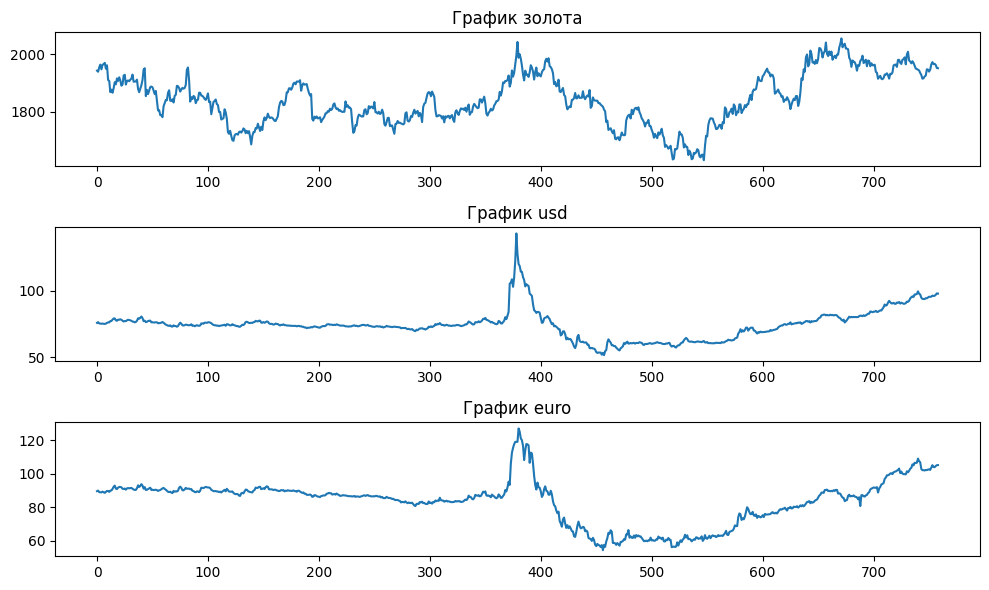

In [35]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(df[:,0])
plt.title('График золота')

plt.subplot(3, 1, 2)
plt.plot(df[:,1])
plt.title('График usd')

plt.subplot(3, 1, 3)
plt.plot(df[:,2])
plt.title('График euro')

# Отображаем графики
plt.tight_layout()
plt.show()

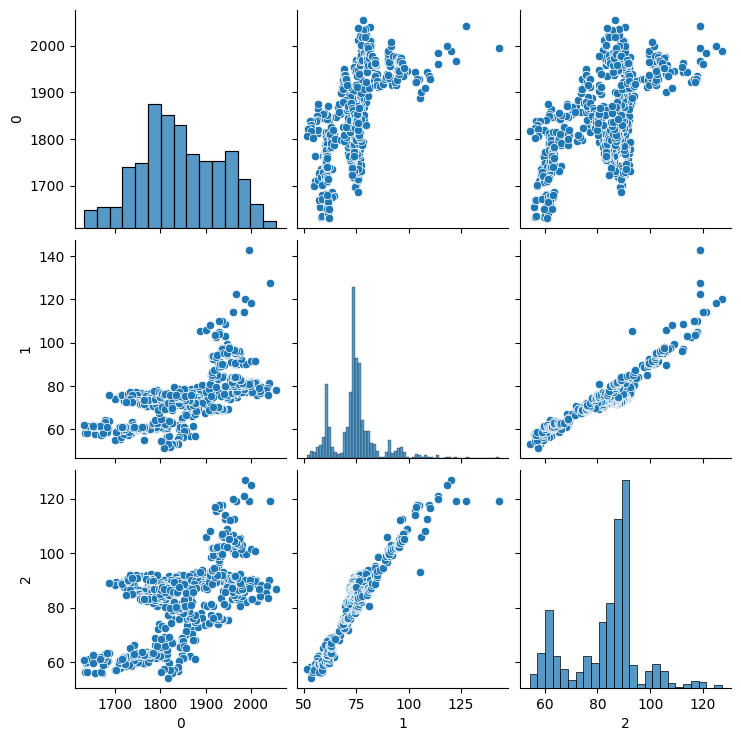

In [36]:
sns.pairplot(pd.DataFrame(df))

# Отображение графиков
plt.show()

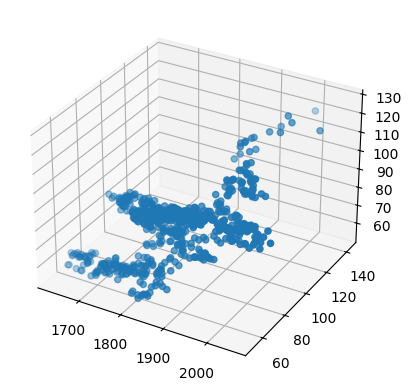

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
a= ax.scatter(df[:, 0], df[:, 1], df[:, 2])

In [10]:
stats = np.array([[0,0],[0,0],[0,0]])
for i in range(3):
    stats[i] = df.T[i].mean(), df.T[i].std()
    df.T[i] = (df.T[i]-df.T[i].mean())/df.T[i].std()

In [11]:
svd = np.linalg.svd(df.T)
svd[:2]

(array([[-0.51342099,  0.85541146,  0.06833834],
        [-0.61231   , -0.30938554, -0.72756928],
        [-0.6012282 , -0.41539358,  0.68262202]]),
 array([42.95931199, 19.28881797,  7.7096702 ]))

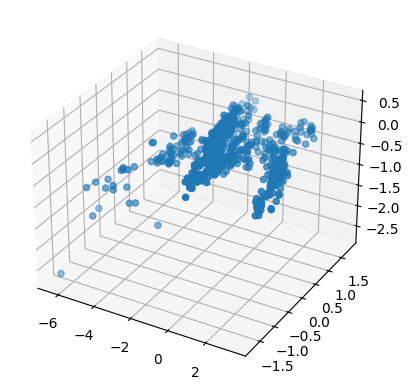

In [12]:
main_componets = svd[0].T@df.T
main_componets = main_componets.T
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
a= ax.scatter(main_componets[:, 0], main_componets[:, 1], main_componets[:, 2])

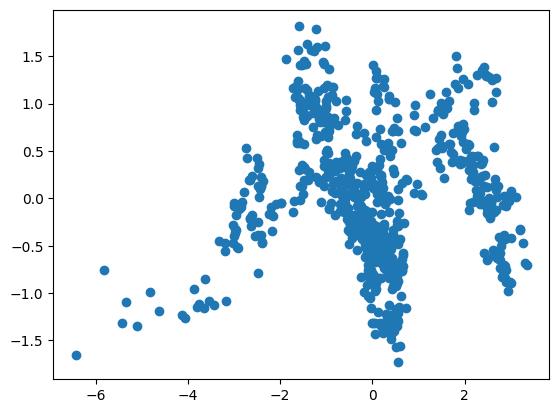

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
a= ax.scatter(main_componets[:, 0], main_componets[:, 1])

In [153]:
input_img = Input(shape=(3,))
y= Dense(256, activation='relu')(input_img)
encoded = Dense(2, activation='linear')(y)

# Создание модели декодера
input_enc = Input(shape=(2,))
x= Dense(256, activation='relu')(input_enc)
decoded = Dense(3, activation='linear')(x)

# Создание автоэнкодера
encoder = keras.Model(input_img, encoded, name="encoder")
decoder = keras.Model(input_enc, decoded, name="decoder")
autoencoder = keras.Model(input_img, decoder(encoder(input_img)), name="autoencoder")

# Компиляция модели
autoencoder.compile(optimizer='adam', loss='mse')

In [159]:
autoencoder.fit(df, df, epochs=500, batch_size=32, validation_split=0)

Epoch 1/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 8/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 9/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 10/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 11/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 12/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 13/500
24/24 [=================

In [160]:
h = encoder.predict(df)
dec = decoder.predict(h)

fake_main_comp = main_componets
fake_main_comp[: , 2] = 0
main_comp_dec = np.linalg.inv(svd[0].T)@fake_main_comp.T
main_comp_dec = main_comp_dec.T

print("neuron error:",np.sum(mean_squared_error(df, dec)))
print("svd error:", np.sum(mean_squared_error(df, main_comp_dec)))

24/24 [==============================] - 0s 1ms/step
neuron error: 2.3014793
svd error: 19.813004848471735


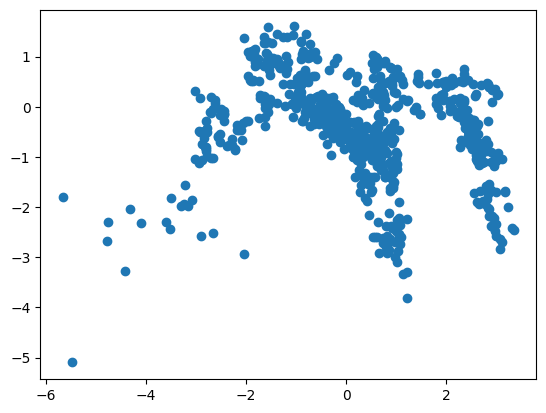

In [161]:
fig = plt.figure()
ax = fig.add_subplot()
a= ax.scatter(h[:, 0], h[:, 1])

In [93]:
for i in range(3):
    df.T[i] = (df.T[i]-df.T[i].mean())/df.T[i].std()

In [92]:
time_size = 15

x_data = np.zeros((df.shape[0]-time_size, time_size, 3))
y_data = np.zeros((df.shape[0]-time_size, 3))

for i in range(df.shape[0]-time_size):
    y_data[i] = df[time_size+i]
    for j in range(time_size):
        x_data[i, j] = df[i+j]

In [143]:
# Создание модели LSTM
model = Sequential()
model.add(LSTM(128,  input_shape=(time_size, 3)))
# model.add(LSTM(256, input_shape=(time_size, 3), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dense(3))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

In [148]:
# Обучение модели
model.fit(x_data, y_data, epochs=30, batch_size=15, validation_split=0.1)

Epoch 1/30
45/45 [==============================] - 1s 17ms/step - loss: 0.0267 - accuracy: 0.9148 - val_loss: 0.0262 - val_accuracy: 0.8533
Epoch 2/30
45/45 [==============================] - 1s 17ms/step - loss: 0.0260 - accuracy: 0.9163 - val_loss: 0.0326 - val_accuracy: 0.8667
Epoch 3/30
45/45 [==============================] - 1s 16ms/step - loss: 0.0263 - accuracy: 0.9238 - val_loss: 0.0214 - val_accuracy: 0.9200
Epoch 4/30
45/45 [==============================] - 1s 16ms/step - loss: 0.0263 - accuracy: 0.9208 - val_loss: 0.0317 - val_accuracy: 0.8667
Epoch 5/30
45/45 [==============================] - 1s 17ms/step - loss: 0.0255 - accuracy: 0.9268 - val_loss: 0.0296 - val_accuracy: 0.8667
Epoch 6/30
45/45 [==============================] - 1s 17ms/step - loss: 0.0253 - accuracy: 0.9178 - val_loss: 0.0526 - val_accuracy: 0.8133
Epoch 7/30
45/45 [==============================] - 1s 16ms/step - loss: 0.0257 - accuracy: 0.9268 - val_loss: 0.0377 - val_accuracy: 0.8400
Epoch 8/30
45

In [150]:
next_vectors = model.predict(x_data)
next_vectors, df[-1]

24/24 [==============================] - 0s 7ms/step


(array([[0.2775297 , 0.38271305, 0.55475247],
        [0.43853548, 0.46103448, 0.66246563],
        [0.63002634, 0.46028244, 0.7079185 ],
        ...,
        [1.4211679 , 1.9724544 , 1.6107883 ],
        [1.4040399 , 2.0372794 , 1.6476934 ],
        [1.3345349 , 2.099918  , 1.6887667 ]], dtype=float32),
 array([1.21049141, 2.18975554, 1.66173086]))

In [24]:
# # Прогнозирование следующих векторов
# for i in range(3):
#     next_vectors.T[i] = next_vectors.T[i]*stats[i,1]+stats[i,0]
#     y_data.T[i] = y_data.T[i]*stats[i,1]+stats[i,0]

In [78]:
print("mean neuron error:",np.mean(mean_squared_error(next_vectors, y_data)))

mean neuron error: 0.03451230185929951


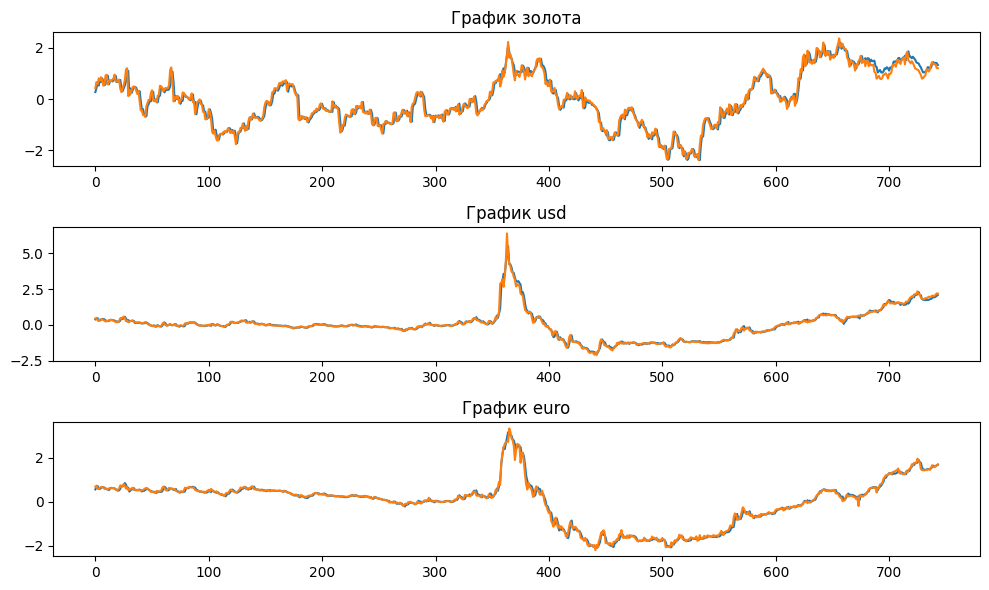

In [151]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(next_vectors[:,0])
plt.plot(y_data[:,0])
plt.title('График золота')

plt.subplot(3, 1, 2)
plt.plot(next_vectors[:,1])
plt.plot(y_data[:,1])
plt.title('График usd')

plt.subplot(3, 1, 3)
plt.plot(next_vectors[:,2])
plt.plot(y_data[:,2])
plt.title('График euro')

# Отображаем графики
plt.tight_layout()
plt.show()

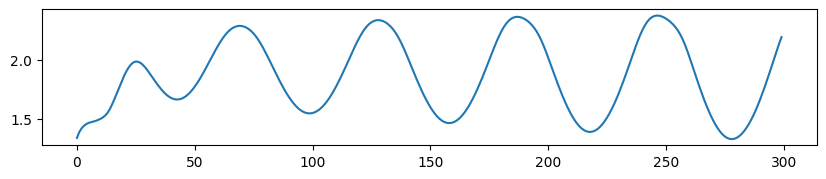

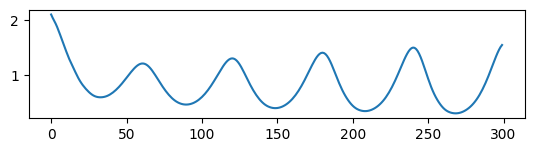

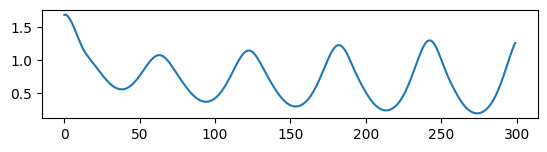

In [152]:
# input_data = np.zeros((1, time_size, 3))

input_data = np.array([x_data[-1]])

predicted_vectors = []
for _ in range(300):
    prediction = model.predict(input_data, verbose=0)
    predicted_vectors.append(prediction[0])
    input_data = np.concatenate((input_data[:, 1:, :], np.expand_dims(prediction, axis=0)), axis=1)

# Создание списков для каждой переменной
var1 = [vector[0] for vector in predicted_vectors]
var2 = [vector[1] for vector in predicted_vectors]
var3 = [vector[2] for vector in predicted_vectors]

# Построение графиков
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(var1)
plt.show()

plt.subplot(3, 1, 2)
plt.plot(var2)
plt.show()

plt.subplot(3, 1, 3)
plt.plot(var3)
plt.show()

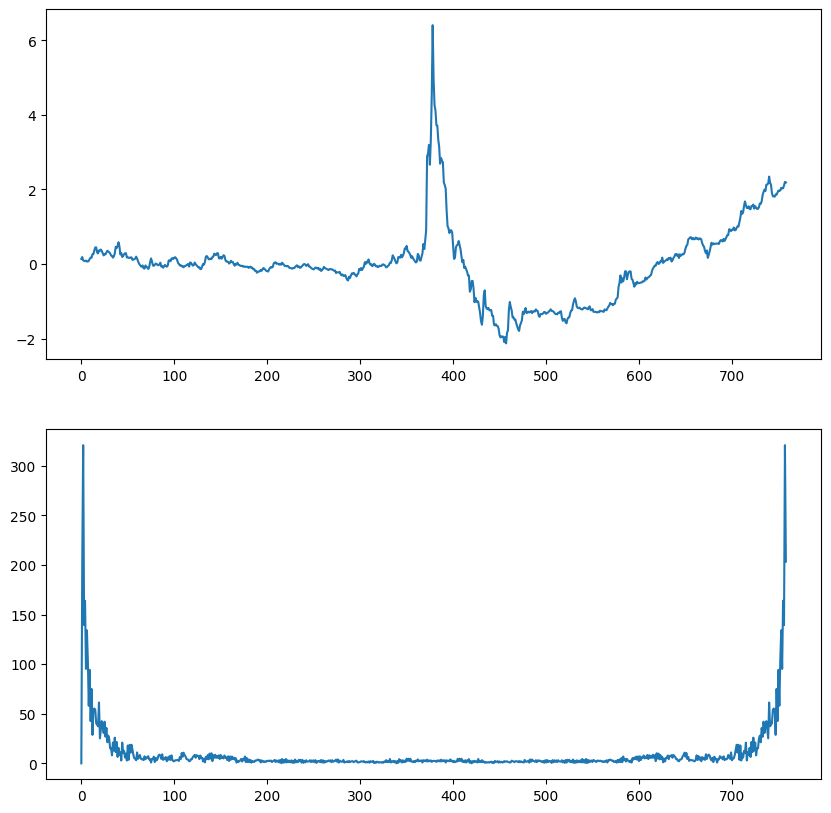

In [28]:
# Пример входного массива
signal = df.T[1]

# Выполняем преобразование Фурье
fourier =np.fft.fft(signal)
    
# Вычисляем модуль каждой частоты
magnitude_spectrum = np.abs(fourier)

# Построение графика модуля каждой частоты
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.subplot(2, 1, 2)
plt.plot(magnitude_spectrum)
plt.show()

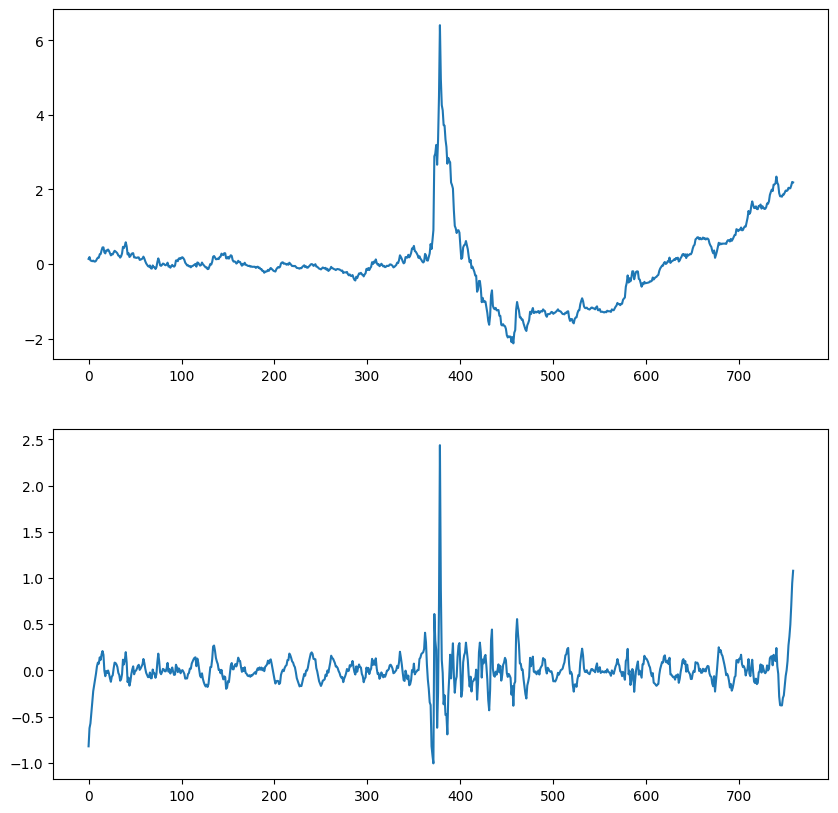

In [44]:
change = 60

sorted_abs_fur = np.sort(abs(fourier))
K=sorted_abs_fur.size-1-change
fourier_k = fourier * (np.abs(fourier) <= sorted_abs_fur[K])
fourier_k_inv = np.fft.ifft(fourier_k).real

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.subplot(2, 1, 2)
plt.plot(fourier_k_inv)
plt.show()